In [1]:
import os
import csv
import time
import sys
import numpy as np
import torch
from fABBA import fabba_model
from src import symbols_rnn 
from src import raw_rnn 
from util import dtw as DTW
import matplotlib.pyplot as plt



In [2]:
def sMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(A - F) / (np.abs(A) + np.abs(F)))

datadir = 'datasets/UCRArchive_2018'
lag = 10
patience = 100

# Add header to csv file
#header = ['Dataset', 'Length', 'Epoch', 'Loss', 'Time', 'sMAPE', 'Euclidean', 'diff_Euclidean', 'DTW', 'diff_DTW']
header = ['Dataset', 'Length', 'Time', 'sMAPE', 'Euclidean', 'diff_Euclidean', 'DTW', 'diff_DTW']
if not os.path.isfile('results/ABBA_LSTM_results'+str(lag)+'.csv'):
    with open('results/ABBA_LSTM_results'+str(lag)+'.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(header)

if not os.path.isfile('results/LSTM_results'+str(lag)+'.csv'):
    with open('results/LSTM_results'+str(lag)+'.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(header)


In [3]:
split=0.5
tol=0.01
alpha=0.05
ws=12
patience=10
hidden_dim=36
num_rnn_layers=1
learning_rate=0.01

Dataset: DodgerLoopWeekend Lag: 10


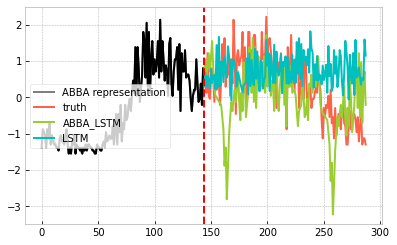

Dataset: Wine Lag: 10
Time series too short
Dataset: Strawberry Lag: 10
Time series too short
Dataset: ItalyPowerDemand Lag: 10
Time series too short
Dataset: PLAID Lag: 10


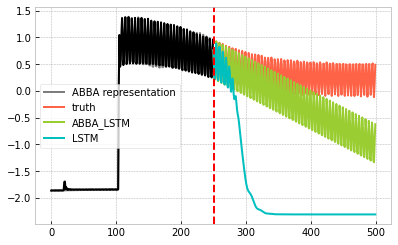

Dataset: BirdChicken Lag: 10
Time series too short
Dataset: ProximalPhalanxTW Lag: 10
Time series too short
Dataset: Symbols Lag: 10
Time series too short
Dataset: FiftyWords Lag: 10
Time series too short
Dataset: ChlorineConcentration Lag: 10
Time series too short
Dataset: Lightning2 Lag: 10


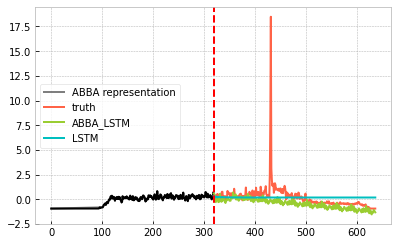

Dataset: UWaveGestureLibraryX Lag: 10
Time series too short
Dataset: FacesUCR Lag: 10
Time series too short
Dataset: Plane Lag: 10
Time series too short
Dataset: RefrigerationDevices Lag: 10


KeyboardInterrupt: 

In [5]:
# Run through dataset

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

plt.style.use('bmh')
for root, dirs, files in os.walk(datadir):
    if dirs != []:
        for dataset in dirs:
            try:
                print('Dataset:', dataset, 'Lag:', lag)
                # if os.path.isfile('results/lstm_plots/' + dataset + '_' + str(lag) + '.pdf'):
                #     raise RuntimeError('Already complete.')

                # Import time series
                with open(datadir+'/'+dataset+'/'+dataset+'_TEST.tsv') as tsvfile:
                    tsvfile = csv.reader(tsvfile, delimiter='\t')
                    col = next(tsvfile)
                    ts = [float(i) for i in col]

                # remove class information
                ts = np.array(ts[1:])
                # remove NaN from time series
                ts = ts[~np.isnan(ts)]

                # Normalise time series
                ts -= np.mean(ts)
                ts /= np.std(ts)
                
                fcast_len = int(round(split*len(ts)))
                train = ts[:-fcast_len]
                test = ts[-fcast_len:]

                # Build ABBA constructor
                # abba = ABBA(tol=0.05, max_k = 10, verbose=0)
                # string, centers = abba.transform(train)
                # abba_numerical = abba.inverse_transform(string, centers, train[0])

                # Build fABBA constructor
                fabba = fabba_model(tol=tol, alpha=alpha, sorting='2-norm', scl=1, verbose=0)

                string_fabba = fabba.fit_transform(train)            # string representation of the time series
                fabba_numerical = fabba.inverse_transform(string_fabba, train[0]) # numerical time series reconstruction
                if len(train) < 100:
                    raise RuntimeError('Time series too short')
                if len(string_fabba) < 20:
                    raise RuntimeError('Time series too short')

                segment_st, segment_ed = len(fabba_numerical), len(fabba_numerical)+len(test)
                # LSTM model with ABBA
                t0 = time.time()
                # f = forecaster(train, model=batchless_VanillaLSTM_pytorch(lag=lag), abba=abba)
                # f.train(patience=patience, max_epoch=10000+patience)
                # forecast1 = f.forecast(len(test)).tolist()
                new_string = symbols_rnn.fit_predict(string_fabba, ws=ws, step=len(test), test_rate=(1, 0, 0), 
                    patience=patience, hidden_dim=hidden_dim, num_rnn_layers=num_rnn_layers, learning_rate=learning_rate,
                    num_epoch=100, variant='LSTM', return_series=False, verbose=0)
                forecast1 = np.array(fabba.inverse_transform(string_fabba+new_string, ts[0]))[segment_st:segment_ed] # numerical time series reconstruction
                t1 = time.time()

                with open('results/fABBA_LSTM_results'+str(lag)+'.csv', 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile, delimiter=' ',
                                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
                    #epoch = len(model1.loss)-patience
                    #loss = model1.loss[epoch]
                    t = t1 - t0
                    smape = sMAPE(test, forecast1)
                    euclid = np.linalg.norm(test - forecast1)
                    diff_euclid = np.linalg.norm(np.diff(test)-np.diff(forecast1))
                    dtw = DTW(test, forecast1)
                    diff_dtw = DTW(np.diff(test), np.diff(forecast1))

                    #row = [dataset, len(string_fabba), epoch, loss, t, smape, euclid, diff_euclid, dtw, diff_dtw]
                    row = [dataset, len(string_fabba), t, smape, euclid, diff_euclid, dtw, diff_dtw]
                    writer.writerow(row)

                # LSTM model without fABBA
                t0 = time.time()
                # f = forecaster(train, model=batchless_VanillaLSTM_pytorch(lag=lag), abba=None)
                # f.train(patience=patience, max_epoch=10000+patience)
                # forecast2 = f.forecast(len(test)).tolist()
                forecast2 = raw_rnn.fit_predict(train, ws=ws, step=len(test), test_rate=(1, 0, 0), 
                    patience=patience, hidden_dim=hidden_dim, num_rnn_layers=num_rnn_layers, learning_rate=learning_rate,
                    num_epoch=100, variant='GRU', verbose=0)[segment_st:segment_ed]
                t1 = time.time()

                with open('./LSTM_results'+str(lag)+'.csv', 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile, delimiter=' ',
                                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
                    #epoch = len(model2.loss)-patience
                    #loss = model2.loss[epoch]
                    t = t1 - t0
                    smape = sMAPE(test, forecast2)
                    euclid = np.linalg.norm(test - forecast2)
                    diff_euclid = np.linalg.norm(np.diff(test)-np.diff(forecast2))
                    dtw = DTW(test, forecast2)
                    diff_dtw = DTW(np.diff(test), np.diff(forecast2))

                    #row = [dataset, len(train), epoch, loss, t, smape, euclid, diff_euclid, dtw, diff_dtw]
                    row = [dataset, len(train), t, smape, euclid, diff_euclid, dtw, diff_dtw]
                    writer.writerow(row)

                    # Produce plots
                    plt.rcParams['axes.facecolor'] = 'white'
                    plt.subplots_adjust(left=0.125, bottom=None, right=0.95, top=None, wspace=None, hspace=None)
                    plt.plot(train, 'k')
                    plt.plot(fabba_numerical, 'k', alpha=0.5, label='ABBA representation')
                    plt.plot(np.arange(len(train), len(train)+len(test), 1), test, 'tomato', label='truth')
                    plt.plot(np.arange(len(train), len(train)+len(test), 1), forecast1, 'yellowgreen', label='ABBA_LSTM')
                    plt.plot(np.arange(len(train), len(train)+len(test), 1), forecast2, 'c', label='LSTM')
                    plt.axvline(x=len(train), c='r', linestyle='--')
                    plt.legend(loc=6)
                    plt.savefig('results/lstm_plots/' + dataset + '_' + str(lag) + '.pdf')
                    plt.show()
                    plt.close()
            except Exception as e:
                print(e)
